# Simple 2 Moving Average Model

In [1]:
import numpy as np
import pandas as pd
import pandas_datareader as pdr
import matplotlib.pyplot as plt
import yfinance as yf
from datetime import date, timedelta
from sharpe import gen_sharpe
from fin_table_obj import Table
from ma_cross_obj import MovingAverageTable

Downloading Data:

In [2]:
# YYYY-MM-DD
start = "2010-04-25"

# for current day: str(date.today() - timedelta(1))
end = str(date.today() - timedelta(1))

# moving Averages, MA1 is always smaller than MA2
ma1 = "50"
ma2 = "250"

# model trading days input for crossover visualization in days. standard 1Y is 252 days. Can use multiples of 252 to track years
model_days = 252 * 5

#multi_level_index = False | removes ticker noise in table
QQQ = (yf.download("QQQ", start, end, multi_level_index = False))

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


# Complete Table Creation

In [3]:
QQQ_table = Table(QQQ)
QQQ_table.gen_table()

,Day Count,Open,High,Low,Close,Return,Cumulative Return,Volatility
Date,,,,,,,,
2010-04-26,1,44.152,44.222,43.917,44.013,NaN,NaN,NaN
2010-04-27,2,43.838,44.030,42.965,43.078,-2.145,-2.123,NaN
2010-04-28,3,43.305,43.332,42.764,43.105,0.061,-2.063,NaN
2010-04-29,4,43.349,43.943,43.314,43.856,1.727,-0.357,NaN
2010-04-30,5,43.838,43.908,42.956,42.991,-1.991,-2.321,NaN
...,...,...,...,...,...,...,...,...
2025-04-17,3770,447.170,447.750,441.360,444.100,-0.018,909.027,3.553
2025-04-21,3771,438.230,439.080,427.930,433.110,-2.506,884.057,3.534
2025-04-22,3772,438.820,447.580,437.620,444.480,2.591,909.891,3.564


In [4]:
QQQ_ma_table = MovingAverageTable(QQQ, ma1, ma2)
QQQ_ma_table.gen_table()

,Day Count,Open,High,Low,Close,50-day MA,250-day MA,Return,Cumulative Return,Model Return,Cumulative Model Return,Signal,Entry
Date,,,,,,,,,,,,,
2011-04-20,251,50.775,51.074,50.713,51.022,50.197,44.772,2.236,15.925,2.236,2.261,1,1.0
2011-04-21,252,51.515,51.542,51.268,51.427,50.196,44.800,0.792,16.846,0.792,3.074,1,0.0
2011-04-25,253,51.471,51.586,51.374,51.559,50.204,44.833,0.257,17.146,0.257,3.339,1,0.0
2011-04-26,254,51.691,52.035,51.577,51.850,50.214,44.867,0.563,17.807,0.563,3.922,1,0.0
2011-04-27,255,51.947,52.264,51.709,52.203,50.222,44.899,0.678,18.608,0.678,4.629,1,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-04-17,3770,447.170,447.750,441.360,444.100,488.631,483.062,-0.018,909.027,-0.018,434.344,1,0.0
2025-04-21,3771,438.230,439.080,427.930,433.110,486.992,483.155,-2.506,884.057,-2.506,421.121,1,0.0
2025-04-22,3772,438.820,447.580,437.620,444.480,485.078,483.239,2.591,909.891,2.591,434.801,1,0.0


# MA Cross-Over Grid Visualization

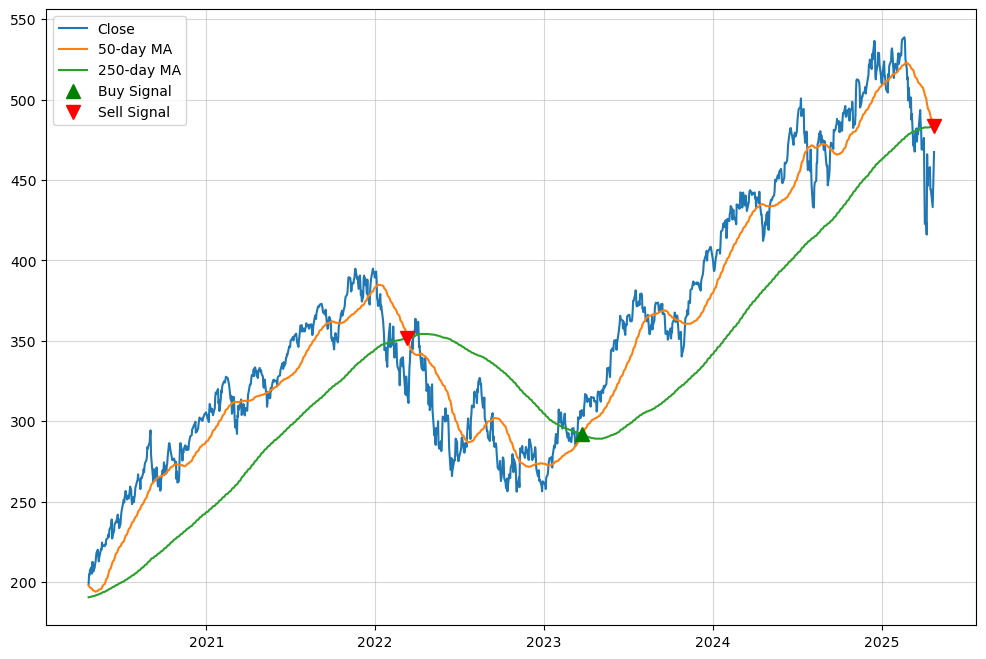

In [5]:
QQQ_ma_table.gen_ma_cross_visual(model_days)

# Buy/Hold to SMA Returns Comparison

Cumulative Buy/Hold Return: 961.85
Cumulative Model Return: 431.96


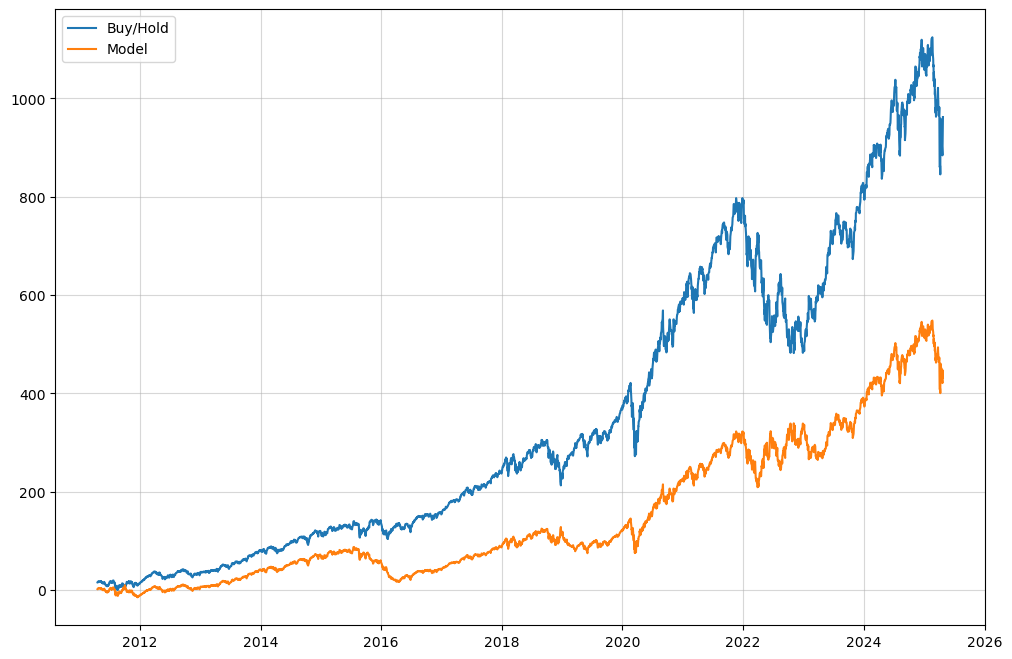

In [6]:
QQQ_ma_table.gen_buyhold_comp()

# Sharpe Ratio:

In [7]:
print('Buy/Hold Sharpe Ratio:', round(gen_sharpe(QQQ_table.gen_table()['Return']), 2))
print('Model Sharpe Ratio:', round(gen_sharpe(QQQ_ma_table.gen_table()['Model Return']), 2))

Buy/Hold Sharpe Ratio: 0.75
Model Sharpe Ratio: 0.59


# Volatility

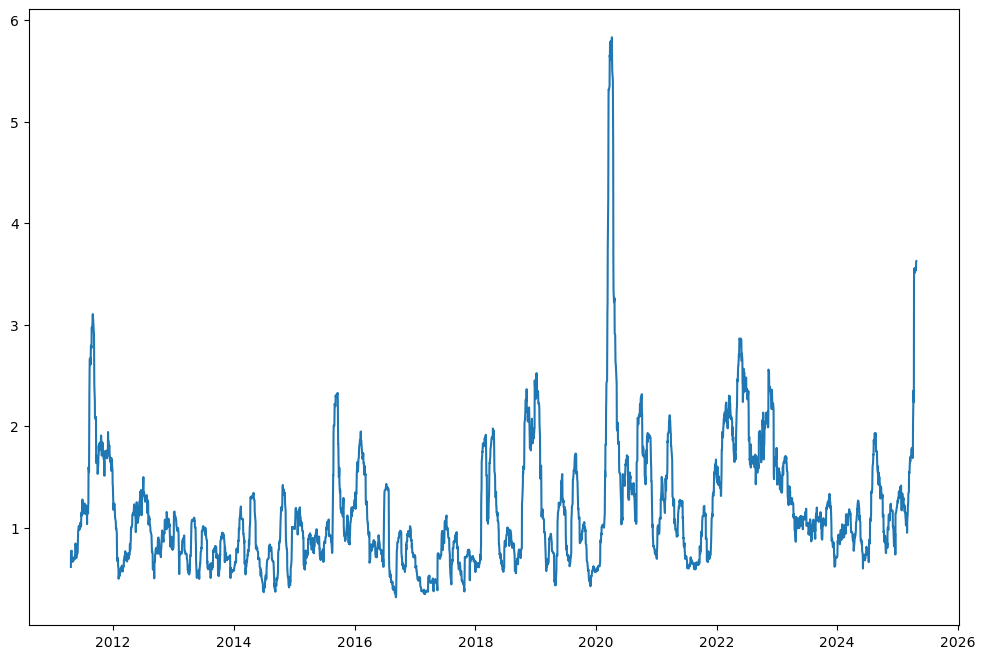

In [8]:
plt.plot(QQQ.Volatility)